Zestimate Home занимаются оценкой стоимости недвижимости.
«Zestimates» - это оценочные значения стоимости дома, основанные на 7,5 миллионах статистических моделей и моделей машинного обучения, которые анализируют сотни точек данных по каждому объекту недвижимости. 

Есть данные об ошибке их прогноза

𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟 = 𝑙𝑜𝑔 (𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒) −𝑙𝑜𝑔 (𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒)

Мы хотим спрогнозировать logerror.



<h1> Будем проверять гипотезу о связи плотности участков </h1>

Высокая плотность участков указывает на большое количество точек данных в его географическом регионе. Эта `` плотность '' вокруг участка может быть связана с прогнозируемой нами логической ошибкой, поскольку производительность модели (т.е. логарифмическая ошибка) обычно зависит от количества репрезентативных данных, на которых она была обучена. Поэтому проверим следующую гипотезу:

<h3> Гипотеза: более высокая плотность участков связана с меньшей абсолютной логической ошибкой. </h3>
<p> </p>
<p> </p>


Давайте начнем!


<h1> 1. Импорт </h1>
Сначала импортируем нужные нам пакеты. Затем мы импортируем данные. Поскольку мы хотим знать взаимосвязь между логарифмической ошибкой и плотностью участков, для анализа нам нужны только строки из обучающего набора, содержащие координаты x, y. К остальным данным вернемся позже.

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr
from scipy.stats import rankdata


In [2]:
train = pd.read_csv('./data/train_2016_v2.csv')
props = pd.read_csv('./data/properties_2016.csv',low_memory=False)
train_ = train.merge(props,how='left',on='parcelid')
train_.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [3]:
train = train_[['parcelid','longitude','latitude','logerror']]
train.dropna(inplace=True) 
display(train.head())
print("shape = ",train.shape)

/var/folders/df/dz8wtw0j7791hg98mrx_thxc0000gn/T/ipykernel_35302/3980260262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


,parcelid,longitude,latitude,logerror
0,11016594,-118488536.0,34280990.0,0.0276
1,14366692,-117677556.0,33668120.0,-0.1684
2,12098116,-118175032.0,34136312.0,-0.0040
3,12643413,-118309000.0,33755800.0,0.0218
4,14432541,-117700234.0,33485643.0,-0.0050


shape =  (90275, 4)


<h1> 2. Восстановление распределения</h1>

«Оценка ядерной плотности» или KDE. Он оценивает функцию плотности вероятности по заданным точкам данных. В нашем случае эти точки данных являются географическими координатами участков.



Будем использовать гауссовское ядро.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Kernel_density.svg/250px-Kernel_density.svg.png)

Для оптимизации  производительности  функции я уже задала некоторые параметры для KDTree

In [4]:
def get_pde(train,bw):
    x = train['longitude'].values
    y = train['latitude'].values
    xy = np.vstack([x,y])
    X = np.transpose(xy)
    #tree = KDTree(X,leaf_size = 20 )     
    #parcelDensity = tree.kernel_density(X, h=bw,kernel='gaussian',rtol=0.00001)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw,rtol=0.00001).fit(X)
    parcelDensity = kde.score_samples(X)
    return parcelDensity

In [5]:
parcelDensity30000 = get_pde(train,30000)
parcelDensity1000 = get_pde(train,1000)
parcelDensity300 = get_pde(train,300)


<h3> 2.1 Визуализация плотности участков с шириной окна 30 000 </h3>
Давайте визуализируем результаты нашего KDE в виде диаграммы разброса. Мы используем долготу и широту наших участков как координаты x, y и раскрашиваем эти точки по их плотности. На графике четко показаны наиболее плотные области ярко-желтым цветом, более полуцентральные участки - оранжевым, периферийные участки - фиолетовым, а относительно изолированные места - черным.

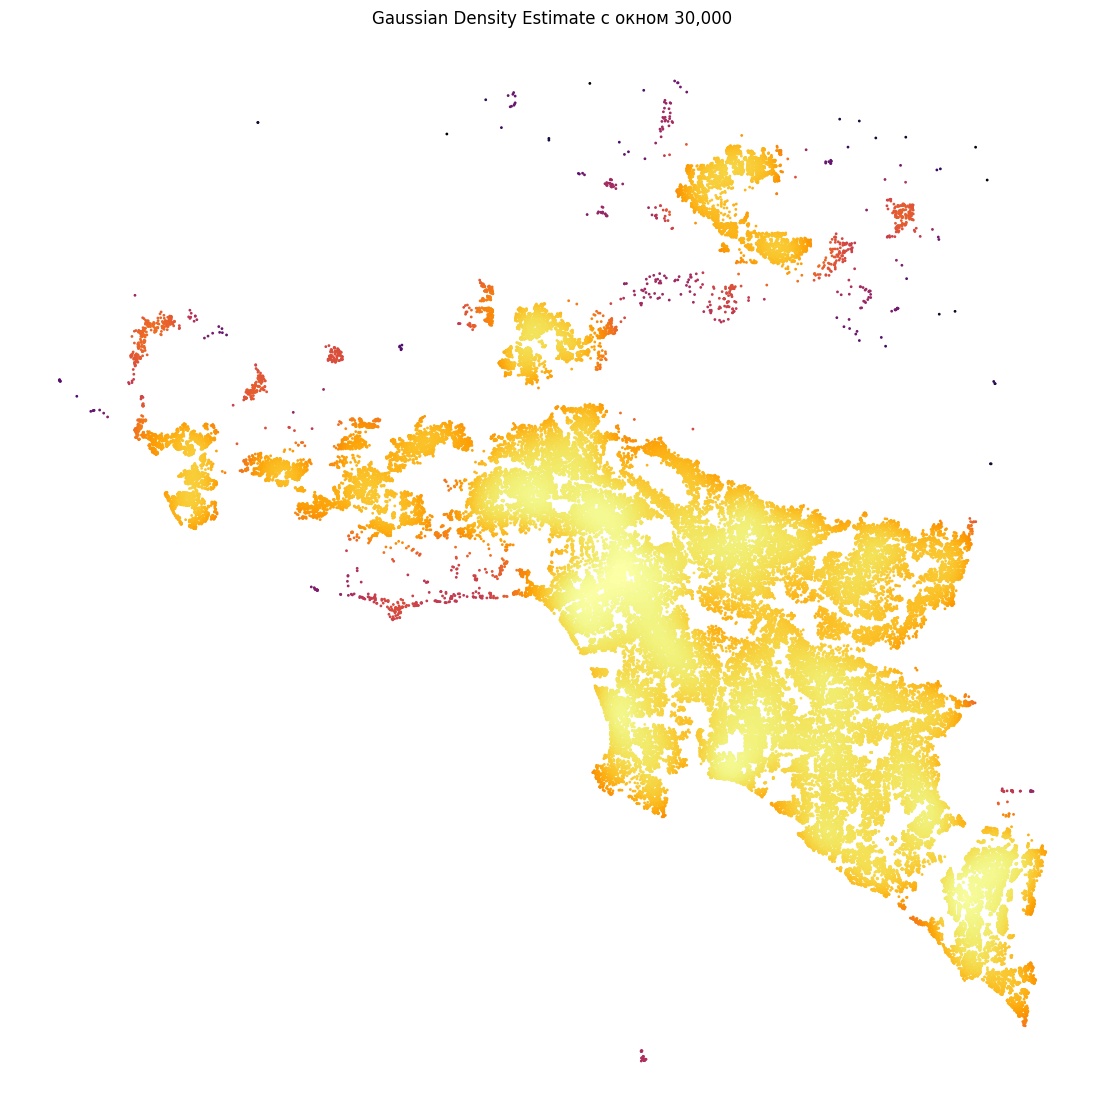

In [6]:
plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Gaussian Density Estimate с окном 30,000")
plt.scatter(x=train['longitude'].values, y=train['latitude'].values, c=parcelDensity30000,cmap='inferno', s=1)


Ярко-желтая плотная область на карте почти идеально сочетается с тем, что Google Maps определяет как центр Лос-Анджелеса. Это означает, что функция плотности участков теперь содержит информацию о центральности определенного участка. 
https://www.google.nl/maps/place/Downtown,+Los+Angeles,+CA,+USA/@33.9761623,-118.5305526,10z/data=!4m5!3m4!1s0x80c2c634253dfd01:0x26fe52df19a5a920!8m2!3d34.040713!4d-118.2467693 

<h3> 2.2 Визуализация плотности участков с шириной окна 1000 и 300 </h3>
В KDE с меньшим размером окна локальные колебания относительно сильны и не могут вызвать выбросы, которые превосходят «нормальные» колебания в KDE на изображении графика. Чтобы улучшить видимость умеренных колебаний, оценим KDE для этих графиков по их процентилям.

In [7]:
rankScaled30000 = 100*rankdata(parcelDensity30000)/len(parcelDensity30000)
rankScaled1000 = 100*rankdata(parcelDensity1000)/len(parcelDensity1000)
rankScaled300 = 100*rankdata(parcelDensity300)/len(parcelDensity300)

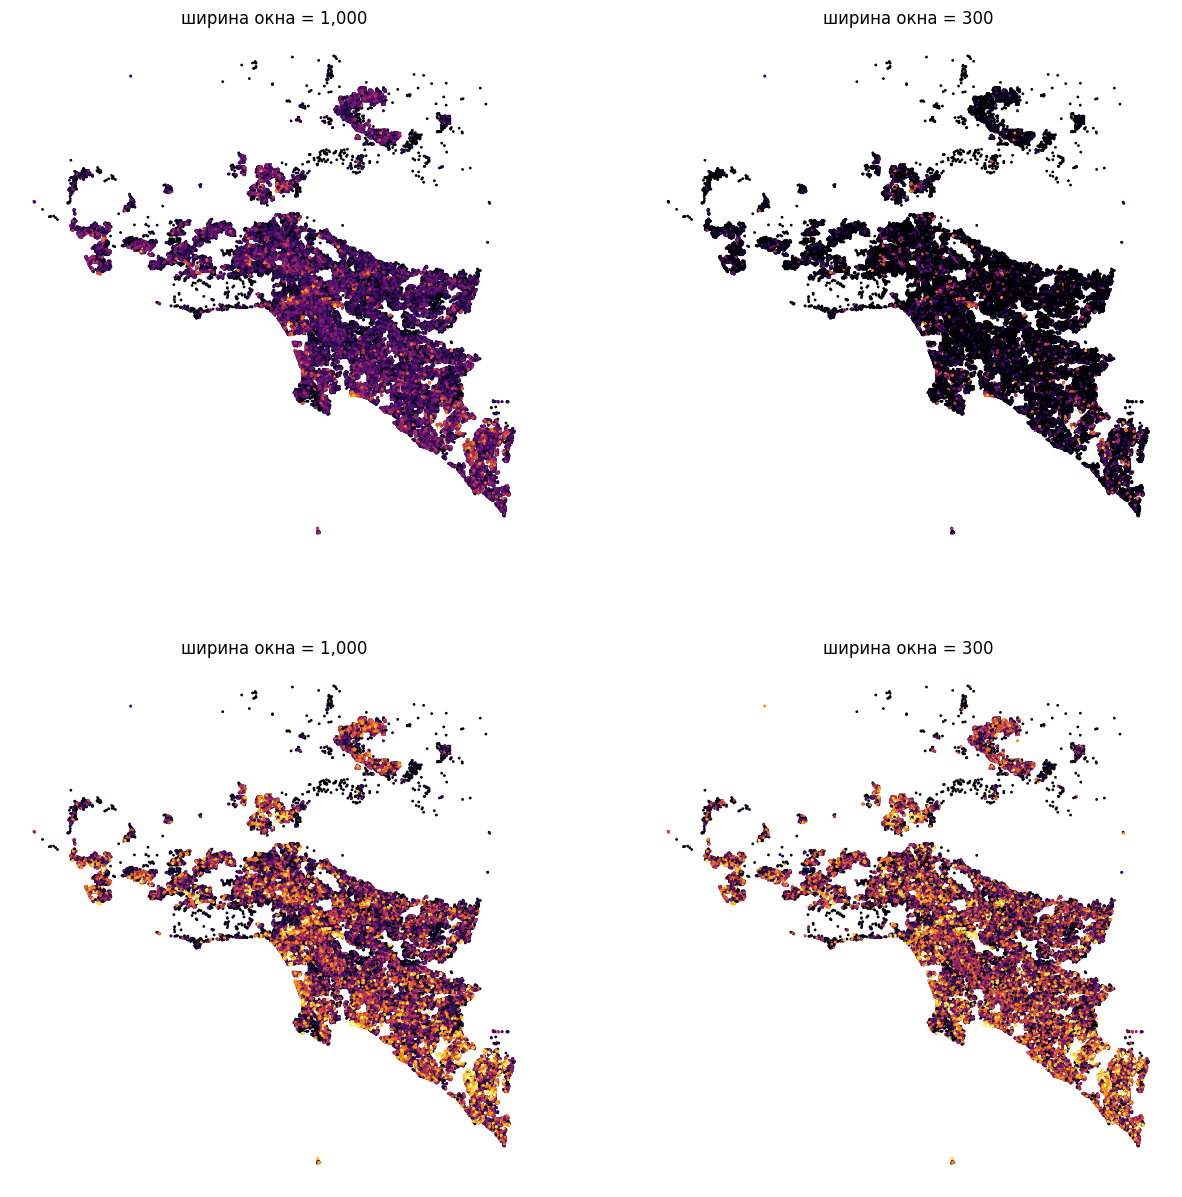

In [8]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(221)
ax1.set_title('ширина окна = 1,000')
ax1.set_axis_off()
ax1.scatter(train['longitude'].values, train['latitude'].values, c=parcelDensity1000,cmap='inferno', s=1)

ax2 = fig.add_subplot(222)
ax2.set_title('ширина окна = 300')
ax2.set_axis_off()
ax2.scatter(train['longitude'].values, train['latitude'].values, c=parcelDensity300,cmap='inferno', s=1)


ax3 = fig.add_subplot(223)
ax3.set_title('ширина окна = 1,000')
ax3.set_axis_off()
ax3.scatter(train['longitude'].values, train['latitude'].values, c=rankScaled1000,cmap='inferno', s=1)

ax4 = fig.add_subplot(224)
ax4.set_title('ширина окна = 300')
ax4.set_axis_off()
ax4.scatter(train['longitude'].values, train['latitude'].values, c=rankScaled300,cmap='inferno', s=1)



<h1> 3. Результаты </h1>
Мы хотим проверить, связаны ли более высокие значения KDE с более низкими абсолютными ошибками. Поэтому мы хотим сравнить KDE с абсолютной ошибкой logerror. Измерим корреляцию Пирсона для 3 размеров окна.

<h3> 3.1 Результат окна 30 000 </h3>
подробно рассмотрим результаты для окна 30 000.

In [9]:
abs_logerrors = np.abs(train['logerror'].values)

In [10]:
corrCoef_30000, _ = pearsonr(parcelDensity30000,abs_logerrors)

print("Результат для окна 30,000:", corrCoef_30000)

Результат для окна 30,000: -0.022125849537554625


нет значимой отрицательной корреляции между функцией плотности и абсолютной логической ошибкой с окном 30 000


<h3> 3.2 Результаты для окон 1000 и 300 </h3>


In [11]:
corrCoef_1000, _ = pearsonr(parcelDensity1000,abs_logerrors)
corrCoef_300, _ = pearsonr(parcelDensity300,abs_logerrors)

print("для окна 1,000, Correlation Coefficient: ",corrCoef_1000)
print()
print("для окна 500, Correlation Coefficient: ",corrCoef_300)




для окна 1,000, Correlation Coefficient:  -0.05989955393141726

для окна 500, Correlation Coefficient:  -0.046042675578440904


для 1,000 и 300 существует значительная отрицательная корреляция между KDE и абсолютной логической ошибкой.


<h1> 4. Заключение </h1>
Результат показывает, что более высокая плотность связана с меньшими абсолютными ошибками. Эта гипотеза подтвердилась для окон 1000 и 300. Неожиданно противоположная зависимость наблюдалась для  30 000. В целом, это означает, что плотность участков может быть полезным признаком для прогнозирования логической ошибки Zestimate и ее добавление может значительно улучшить результаты предсказаний, и на примере Zestimate, поможет им делать более точные прогнозы.


In [12]:
cat_features = [i for i in train_.columns if train_[i].dtype !='float64']
cat_features

['parcelid',
 'transactiondate',
 'hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'fireplaceflag',
 'taxdelinquencyflag']

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(cat_features=cat_features, iterations=200, random_state=42)

X = train_.drop(['logerror'], axis = 1)
X[cat_features] = X[cat_features].fillna("")
y = train_['logerror']*100
scores = -np.mean(cross_val_score(cbr, X, y, cv=3, scoring='neg_mean_absolute_error'))
scores

Learning rate set to 0.289467
0:	learn: 15.2670682	total: 87.9ms	remaining: 17.5s
1:	learn: 15.2407607	total: 118ms	remaining: 11.7s
2:	learn: 15.2256536	total: 139ms	remaining: 9.1s
3:	learn: 15.2029695	total: 167ms	remaining: 8.18s
4:	learn: 15.1878066	total: 189ms	remaining: 7.39s
5:	learn: 15.1770020	total: 213ms	remaining: 6.87s
6:	learn: 15.1564519	total: 236ms	remaining: 6.52s
7:	learn: 15.1428355	total: 258ms	remaining: 6.19s
8:	learn: 15.1280360	total: 281ms	remaining: 5.96s
9:	learn: 15.1179850	total: 303ms	remaining: 5.76s
10:	learn: 15.1129472	total: 326ms	remaining: 5.61s
11:	learn: 15.0946243	total: 350ms	remaining: 5.48s
12:	learn: 15.0884720	total: 374ms	remaining: 5.39s
13:	learn: 15.0764609	total: 397ms	remaining: 5.28s
14:	learn: 15.0742329	total: 419ms	remaining: 5.17s
15:	learn: 15.0712226	total: 447ms	remaining: 5.13s
16:	learn: 15.0619443	total: 473ms	remaining: 5.09s
17:	learn: 15.0480128	total: 500ms	remaining: 5.06s
18:	learn: 15.0346188	total: 533ms	remaining

7.092218861783432

In [79]:
scores

7.070652434754578

In [14]:
train_2 = pd.concat([train_, 
                     pd.DataFrame([parcelDensity1000,
                                   parcelDensity300]).T], 
                    axis = 1)

In [15]:
cbr = CatBoostRegressor(cat_features=cat_features, iterations=200, random_state=42)

X = train_2.drop(['logerror'], axis = 1)
X[cat_features] = X[cat_features].fillna("")
y = train_['logerror'] * 100
scores = -np.mean(cross_val_score(cbr, X, y, cv=3, scoring='neg_mean_absolute_error'))
scores

Learning rate set to 0.289467
0:	learn: 15.2675578	total: 20.9ms	remaining: 4.17s
1:	learn: 15.2455580	total: 39.7ms	remaining: 3.93s
2:	learn: 15.2277374	total: 63ms	remaining: 4.14s
3:	learn: 15.2032600	total: 86.7ms	remaining: 4.25s
4:	learn: 15.1877268	total: 108ms	remaining: 4.2s
5:	learn: 15.1744422	total: 126ms	remaining: 4.09s
6:	learn: 15.1614199	total: 149ms	remaining: 4.12s
7:	learn: 15.1466932	total: 171ms	remaining: 4.1s
8:	learn: 15.1377525	total: 195ms	remaining: 4.15s
9:	learn: 15.1292720	total: 226ms	remaining: 4.29s
10:	learn: 15.1188902	total: 258ms	remaining: 4.43s
11:	learn: 15.1031938	total: 289ms	remaining: 4.53s
12:	learn: 15.0862744	total: 324ms	remaining: 4.66s
13:	learn: 15.0807128	total: 410ms	remaining: 5.45s
14:	learn: 15.0701480	total: 441ms	remaining: 5.44s
15:	learn: 15.0590456	total: 470ms	remaining: 5.4s
16:	learn: 15.0478828	total: 500ms	remaining: 5.38s
17:	learn: 15.0296150	total: 533ms	remaining: 5.39s
18:	learn: 15.0132238	total: 573ms	remaining:

7.060630695611113

In [16]:
scores

7.060630695611113